In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd
from sklearn import metrics, model_selection
from Utils.handle_file import handle_file
from Utils import utils
import torch
from torch.utils.data import Dataset, DataLoader, Sampler

### Custom dataset

In [ ]:
from torch.utils.data.dataset import Dataset
from Utils.dataLoader_utils import seq_padding, code2index, label2index, position_idx, index_seg

In [ ]:
class FinetuneDataset(Dataset):
    def __init__(self, token2idx, label2idx, mod2idx, age2idx, del2idx, NPI2idx,
                 dataframe, max_len, patid='patid', code='inputs', age='age',
                 label='label',
                 mod='modalities', delay='delays_in_months', NPI='NPI'):
        self.vocab = token2idx
        self.mod2idx = mod2idx
        self.age2idx = age2idx
        self.del2idx = del2idx
        self.npi2idx = NPI2idx
        self.label_vocab = label2idx
        self.max_len = max_len
        self.code = dataframe[code]
        self.age = dataframe[age]
        self.label = dataframe[label]
        self.patid = dataframe[patid]
        self.modalities = dataframe[mod]
        self.delay = dataframe[delay]
        self.npi = dataframe[NPI]


    def __getitem__(self, index):
        """
        return: age, code, position, segmentation, mask, label
        """
        # cut data
        age = self.age[index]
        code = self.code[index]
        label = self.label[index]
        patid = self.patid[index]
        delay = self.delay[index]
        modalities = self.modalities[index]
        npi = self.npi[index]

        # change id type to list
        patid = [patid]

        # extract data
        age = age[(-self.max_len+1):]
        code = code[(-self.max_len+1):]
        delay = delay[(-self.max_len+1):]
        modalities = modalities[(-self.max_len+1):]
        npi = npi[(-self.max_len+1):]

        # mask 0:len(code) to 1, padding to be 0
        mask = np.ones(self.max_len)
        mask[len(code):] = 0

        # pad age sequence and code sequence
        age = seq_padding(age, self.max_len, token2idx=self.age2idx)
        delay = seq_padding(delay, self.max_len, token2idx=self.del2idx)
        modalities = seq_padding(modalities, self.max_len, token2idx=self.mod2idx)
        npi = seq_padding(npi, self.max_len, token2idx=self.npi2idx)

        tokens, code = code2index(code, self.vocab)
        _, label = label2index(label, self.label_vocab)

        # get position code and segment code
        tokens = seq_padding(tokens, self.max_len)
        position = position_idx(tokens)
        segment = index_seg(tokens)

        # pad code and label
        code = seq_padding(code, self.max_len, symbol=self.vocab['PAD'])
        #  label = seq_padding(label, self.max_len, symbol=-1)

        # will be loaded as
        # age_ids, input_ids, mod_ids, del_ids, NPI_ids, posi_ids, segment_ids, attMask, targets, _ = batch

        return torch.LongTensor(age), torch.LongTensor(code), torch.LongTensor(modalities), torch.LongTensor(delay), \
            torch.LongTensor(npi), torch.LongTensor(position), torch.LongTensor(segment), \
            torch.LongTensor(mask), torch.LongTensor(label), torch.LongTensor(patid)

    def __len__(self):
        return len(self.code)

## Data loading and config

In [ ]:
file_config = {
    'data': 'BEHRT/Early_integration/Files/data_for_classification.pkl',
    'index_to_delete': 'BEHRT/Early_integration/Files/index_to_delete.pkl',
    'labels': 'BEHRT/Early_integration/Files/relapses.csv',
    'test_idx': 'BEHRT/Early_integration/Files/test_idx.pkl',
}

In [ ]:
config = {
    'batch_size': 32,
}

In [ ]:
global_params = {
    'min_visit': 3,
    'max_len_seq': 512,
    'max_age': 110,
    'age_month': 12,
    'age_symbol': None,
    'delay_month': 0.25,
    'max_delay': 30,
}

### Train data

In [ ]:
hf = handle_file()

In [ ]:
# Import train data
data = hf._load_pkl(file_config['data'])

In [ ]:
# Import labels
labels = hf._load_csv(file_config['labels'])
labels.rename(columns={'status_rfs_surg_3y': 'label'}, inplace=True)

# Merge label and data
data = pd.merge(data, labels, on=['Num_dossier'])
data.set_index('Num_dossier', inplace=True)
print(data.shape)

# Delete censored patients and relapsed before 18months post surgery
index_to_del = hf._load_pkl(file_config['index_to_delete'])  # 0: 12mo, 1:18mo, 2:24mo, 3:36mo, 4:60mo
list_of_index = index_to_del['list_of_relapses_before_12mo']+index_to_del['list_of_censored_before_3y']
print("%d patients removed before they relapsed too early or were censored" % len(list_of_index))

data = data.reset_index()
data = data.loc[~data['Num_dossier'].isin(list(list_of_index))]
print(data.shape)

# remove patients with visits less than min visit
previous_shape = data.shape[0]
data['length'] = data['inputs_normal_range_preprocessed_100_therap_removed'].apply(lambda x: len([i for i in range(len(x)) if x[i] == 'SEP']))
data = data[data['length'] >= global_params['min_visit']]
print("{} patients removed because they do not have enough visits.".format(previous_shape - data.shape[0]))

(15150, 76)
7012 patients removed before they relapsed too early or were censored
(8138, 77)
0 patients removed because they do not have enough visits.


In [ ]:
test_idx = hf._load_pkl(file_config['test_idx'])
subtrain = data.loc[data['Num_dossier'].isin([i for i in data['Num_dossier'] if i not in test_idx.values])]

### Train-valid split

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(subtrain.drop(['label'], axis=1), subtrain['label'],
                                                                      test_size=0.07, random_state=42, stratify=subtrain['label'])

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
train_df.index = range(train_df.shape[0])
train_df['patid'] = range(train_df.shape[0])

In [ ]:
X_tr = train_df['inputs_normal_range_preprocessed_100_therap_removed']
y_tr = train_df['label']

### Vocabularies

In [ ]:
ageVocab, _ = utils.age_vocab(max_age=global_params['max_age'],
                              mon = global_params['age_month'],
                              symbol=global_params['age_symbol'])

In [ ]:
delayVocab, _ = utils.delay_vocab(max_delay=global_params['max_delay'],
                                  mon = global_params['delay_month'],
                                  symbol=global_params['age_symbol'])

In [ ]:
NPIVocab = {'PAD':0, 'UNK':1, 1.0:2, 2.0:3, 3.0:4, 4.0:5, 5.0:6, 6.0:7}

In [ ]:
# Binary classification
labelVocab = {0:0, 1:1}

In [ ]:
whole_seq = hf._load_pkl('data/whole_seq_preprocessed.pkl')

tokenVocab, _ = utils.input_vocab(inputs=whole_seq.inputs_normal_range_preprocessed_100_therap_removed,
                                  symbol=None)

modalitiesVocab, _ = utils.mod_vocab(whole_seq.modalities_100_therap_removed,
                                     symbol=None)

del whole_seq

## With StratifiedSampler

_Comment:_ `StratifiedSampler` is not a stratified sampler (that would provide the same proportion of pos/neg samples in each batch as in the training data).

In [ ]:
from Utils.dataLoader_utils import StratifiedSampler

In [ ]:
def load_data(data, config, sampling=True, X_tr=None, y_tr=None):
    """
    Create a torch DataLoader that can be used to load the data batch by batch.
    The batch are balanced using StratifiedSampler.
    """
    Dset = FinetuneDataset(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab,
                     age2idx=ageVocab, del2idx=delayVocab, NPI2idx=NPIVocab,
                     dataframe=data, max_len=global_params['max_len_seq'],
                     code='inputs_normal_range_preprocessed_100_therap_removed',
                     delay ='delays_100_therap_removed',
                     age = "age_100_therap_removed",
                     mod ='modalities_100_therap_removed',
                     NPI= 'NPI6')
    if sampling:
        return DataLoader(dataset=Dset, batch_size=config['batch_size'],
                          sampler=StratifiedSampler(X_tr, y_tr, batch_size=config['batch_size']))
    else:
        return DataLoader(dataset=Dset, batch_size=config['batch_size'], shuffle=False)

In [ ]:
train_loader = load_data(train_df, config, X_tr=X_tr, y_tr=y_tr)

#### What samples are used?

In [ ]:
used_samples = []
used_samples_pos = []
used_samples_neg = []
for idx, batch in enumerate(train_loader):
    age_ids, input_ids, mod_ids, del_ids, NPI_ids, posi_ids, segment_ids, attMask, targets, pids = batch
    pids = np.array([int(pid) for pid in pids])
    pos_indices = np.where(targets > 0)[0]
    neg_indices = np.where(targets < 1)[0]
    assert(len(pos_indices) + len(neg_indices) == len(pids))
    assert(len(pos_indices) == len(neg_indices))
    used_samples.extend(pids)
    used_samples_pos.extend([pids[i] for i in pos_indices])
    used_samples_neg.extend([pids[i] for i in neg_indices])

In [ ]:
print("%d positive samples used for training" % len(used_samples_pos))
print("%d negative samples used for training" % len(used_samples_neg))
print("%d samples used for training" % len(used_samples))

3424 positive samples used for training
3424 negative samples used for training
6848 samples used for training


In [ ]:
print("%d unique positive samples used for training" % len(set(used_samples_pos)))
print("%d unique negative samples used for training" % len(set(used_samples_neg)))
print("%d unique samples used for training" % len(set(used_samples)))

252 unique positive samples used for training
2670 unique negative samples used for training
2922 unique samples used for training


In [ ]:
print(len(y_tr), np.sum(y_tr), (len(y_tr) - np.sum(y_tr)))

6853 252 6601


__Conclusion:__ We are far from using all negative examples for training.

#### How many times is each sample used?

In [ ]:
counts = [used_samples_neg.count(neg_idx) for neg_idx in set(used_samples_neg)]

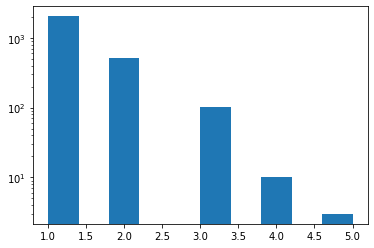

In [ ]:
plt.hist(counts)
plt.yscale('log')

__Conclusion:__ While we're not using all negative samples, many of them are used several times.

In [ ]:
counts = [used_samples_pos.count(pos_idx) for pos_idx in set(used_samples_pos)]

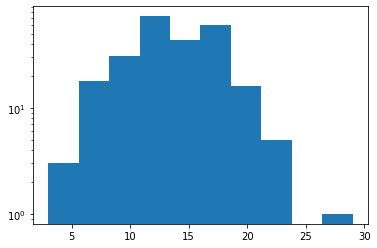

In [ ]:
plt.hist(counts)
plt.yscale('log')

## With new batch over-sampler

In [ ]:
 from sklearn.utils import gen_even_slices

In [ ]:
class NewBatchOverSampler(Sampler):
    """
    Over Sampling
    Provides equal representation of target classes in each batch
    Uses all the data
    Truly splits the data in batches like torch's BatchSampler
    """
    def __init__(self, X, y, batch_size, minority_pct=0.5):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.X = X
        self.y = torch.from_numpy(y.values)
        self.batch_size = batch_size
        self.minority_pct = minority_pct
        # The number of splits/batches depends on how many samples
        # from the minority class we want to put in each batch
        self.n_splits = int(self.y.size(0) / (self.minority_pct * self.batch_size))

    def __iter__(self):
        minority_idxs = np.where(self.y==1)[0]
        majority_idxs = np.where(self.y==0)[0]

        num_majority = len(majority_idxs)
        slices_generator = gen_even_slices(num_majority, self.n_splits)

        # Shuffle the majority class
        np.random.shuffle(majority_idxs)

        # Random oversample of the whole minority class
        # to obtain as many samples as in the majority class
        minority_resampled = np.random.choice(minority_idxs, len(majority_idxs), replace=True)

        for sl in slices_generator:
            #print(sl)
            majority = majority_idxs[sl]
            minority = minority_resampled[sl]
            idxs = list(np.hstack([majority, minority]))
            yield idxs

    def __len__(self):
        # The iterator length is the number of batches
        return self.n_splits

In [ ]:
def new_batch_load_data(data, config, sampling=True, X_tr=None, y_tr=None):
    """
    Create a torch DataLoader that can be used to load the data batch by batch.
    The batch are balanced using NewBatchOverSampler.
    """
    Dset = FinetuneDataset(token2idx=tokenVocab, label2idx=labelVocab, mod2idx=modalitiesVocab,
                     age2idx=ageVocab, del2idx=delayVocab, NPI2idx=NPIVocab,
                     dataframe=data, max_len=global_params['max_len_seq'],
                     code='inputs_normal_range_preprocessed_100_therap_removed',
                     delay='delays_100_therap_removed',
                     age="age_100_therap_removed",
                     mod='modalities_100_therap_removed', NPI='NPI6')
    if sampling:
        return DataLoader(dataset=Dset,
                          batch_sampler=NewBatchOverSampler(X_tr, y_tr, batch_size=config['batch_size']))
    else:
        return DataLoader(dataset=Dset, batch_size=config['batch_size'], shuffle=False)

_Comment:_ I'm using `batch_sampler=` rather than `batch_size=` because `NewBatchOverSampler` yields indices batch by batch.

In [ ]:
new_train_loader = new_batch_load_data(train_df, config, X_tr=X_tr, y_tr=y_tr)

#### What samples are used?

In [ ]:
used_samples = []
used_samples_pos = []
used_samples_neg = []
for idx, batch in enumerate(new_train_loader):
    age_ids, input_ids, mod_ids, del_ids, NPI_ids, posi_ids, segment_ids, attMask, targets, pids = batch
    pids = np.array([int(pid) for pid in pids])
    pos_indices = np.where(targets > 0)[0]
    neg_indices = np.where(targets < 1)[0]
    assert(len(pos_indices) + len(neg_indices) == len(pids))
    assert(len(pos_indices) == len(neg_indices))
    used_samples.extend(pids)
    used_samples_pos.extend([pids[i] for i in pos_indices])
    used_samples_neg.extend([pids[i] for i in neg_indices])

In [ ]:
print("%d positive samples used for training" % len(used_samples_pos))
print("%d negative samples used for training" % len(used_samples_neg))
print("%d samples used for training" % len(used_samples))

6601 positive samples used for training
6601 negative samples used for training
13202 samples used for training


In [ ]:
print("%d unique positive samples used for training" % len(set(used_samples_pos)))
print("%d unique negative samples used for training" % len(set(used_samples_neg)))
print("%d unique samples used for training" % len(set(used_samples)))

252 unique positive samples used for training
6601 unique negative samples used for training
6853 unique samples used for training


In [ ]:
print(len(y_tr), np.sum(y_tr), (len(y_tr) - np.sum(y_tr)))

6853 252 6601


__Conclusion:__ We are now using all samples for training.

#### How many times is each sample used?

In [ ]:
counts = [used_samples_neg.count(neg_idx) for neg_idx in set(used_samples_neg)]

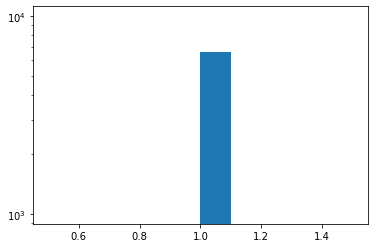

In [ ]:
plt.hist(counts)
plt.yscale('log')

__Conclusion:__ We are now using each negative sample once.

In [ ]:
counts = [used_samples_pos.count(pos_idx) for pos_idx in set(used_samples_pos)]

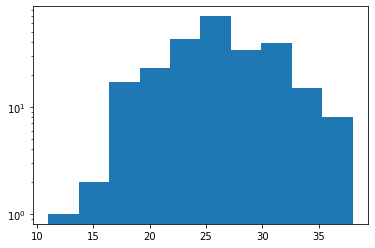

In [ ]:
plt.hist(counts)
plt.yscale('log')